# Milestone 4: Analysis and Visualisation

In [19]:
import pandas as pd
import matplotlib.pyplot as plt 

### Import transformed loans paymentment data that's been cleaned in the previous milestone:

In [20]:
df = pd.read_csv('/Users/hollymorris/Python/exploratory-data-analysis---customer-loans-in-finance994/transformed_loans_data.csv')

## Current state of the loans:

While performing the analysis in this milestone it can be helpful to have the data dictionary on hand to get an overview of what each column represents: data_dictionary.md

We will query the data to check the current state of the payments:

Summarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.

Additionally calculate how much will be paid back in 6 months time with interest. Visualise your results on an appropriate graph.

In [21]:
df['decimal_int_rate'] = df['int_rate'] / 100 # Convert interest rate to decimal form

amount_recovered = df['total_payment'].sum() # Sum of recovered payments across all loans

df['interest_to_be_paid'] = df['loan_amount'] * df['decimal_int_rate'] # Calculate interest to be paid 
df['total_to_be_paid'] = df['interest_to_be_paid'] + df['loan_amount'] # Add interest to loan amount for total to be paid 
total_to_be_paid = df['total_to_be_paid'].sum() # Sum total to be paid of all loans 

percentage_recovered = (amount_recovered / total_to_be_paid) * 100 # Calculate percentage of loans currently recovered

print(f'Percentage of loans that have currently been recovered {percentage_recovered:.2f}%')
print(f'Total amount to be paid over loans term £{total_to_be_paid:.2f}')
print(f'Total amount of loans recovered to date £{amount_recovered:.2f}')

Percentage of loans that have currently been recovered 79.68%
Total amount to be paid over loans term £796587684.03
Total amount of loans recovered to date £634744506.97


In [22]:
payments_over_next_6_mths = df['instalment'] * 6 # Calculate loans to be paid back in 6 months' time 
total_over_next_6_mths = payments_over_next_6_mths.sum() 

print(f'Total amount that will be paid back in 6 months time £{total_over_next_6_mths:.2f}')

Total amount that will be paid back in 6 months time £125642277.54


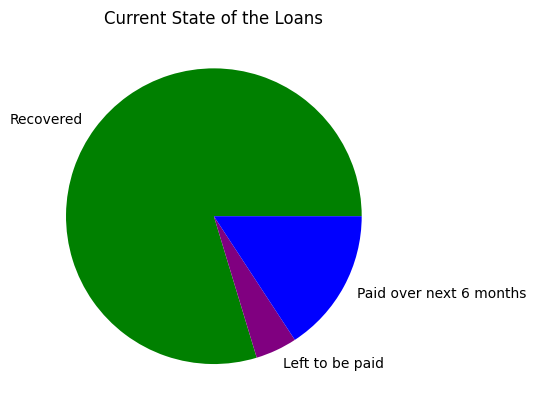

In [23]:
percentage_paid_6_mths = (total_over_next_6_mths/total_to_be_paid) * 100 # Calculate percentage of amount that will be paid over next 6 months 
percentage_left_to_be_paid = 100 - (percentage_recovered + percentage_paid_6_mths) # Calculate percentage that will remain unrecovered in 6 months 

labels = ['Recovered', 'Left to be paid', 'Paid over next 6 months']
percentages = [percentage_recovered, percentage_left_to_be_paid, percentage_paid_6_mths]
colors = ['green', 'purple', 'blue']

plt.figure
plt.pie(percentages, labels=labels, colors=colors)
plt.title('Current State of the Loans')
plt.show()

## Calculating loss:

The company wants to check what percentage of loans have been a loss to the company:

Loans marked as Charged Off in the loan_status column represent a loss to the company.

Calculate the percentage of charged off loans and the total amount that was paid towards these loans before being charged off.

In [24]:
charged_off_loans = df[df['loan_status'] == 'Charged Off'] # Filter loans with status 'Charged Off'
number_charged_off_loans = len(charged_off_loans) # Count number of Charged Off loans in DataFrame
number_all_loans = len(df) # Count total number of rows(loans) in DataFrame
percentage_charged_off_loans = (number_charged_off_loans/number_all_loans) * 100 # Calculate percentage of Charged Off loans 

print(f'Percentage of charged off loans: {percentage_charged_off_loans:.2f}%')

Percentage of charged off loans: 10.06%


In [25]:
total_paid_towards_charged_off_loans = charged_off_loans['total_payment'].sum() # Calculate the total amount paid towards these loans

print(f'Total amount that was paid towards Charged Off loans before being charged off: £{total_paid_towards_charged_off_loans:.2f}')

Total amount that was paid towards Charged Off loans before being charged off: £35893274.67


## Calculating projected loss:


Calculate the expected loss of the loans marked as Charged Off.

Calculate the loss in revenue these loans would have generated for the company if they had finished their term. Visualise the loss projected over the remaining term of these loans.

In [26]:
df['loan_left_unpaid'] = df['loan_amount']  - df['total_payment'] # Calulate how much of Charged Off loan not paid back 
loss_of_loans = df.loc[df['loan_status'] == 'Charged Off', 'loan_left_unpaid'].sum() # Sum for all Charged Off loans 

print(f'Expected loss of loans marked as Charged Off: £{loss_of_loans:.2f}')

Expected loss of loans marked as Charged Off: £36982725.33


In [27]:
df['loan_revenue'] = df['total_to_be_paid'] - df['total_payment'] # Calculate revenue for loans
charged_off_revenue_loss = df.loc[df['loan_status'] == 'Charged Off', 'loan_revenue'].sum() # Sum for all Charged Off loans 

print(f'Loss in revenue these loans would have generated if terms had finished: £{charged_off_revenue_loss:.2f}')

Loss in revenue these loans would have generated if terms had finished: £48573186.75


In [28]:
def transform_dates(df):
    '''
    Converts date_columns in the DataFrame frame to DateTime data type.

    Parameters:
        df: DataFrame the function will be applied to.

    Returns:
        df: the updated DataFrame. 
    '''
    date_columns = [
        'issue_date',
        'last_payment_date'
        ]
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')
    return df

transform_dates(df) # Convert issue_date and last_payment_date to datetime in main dataframe 

df['term'] = df['term'].str.extract(r'(\d+)').astype(int) # Convert term to int data type 

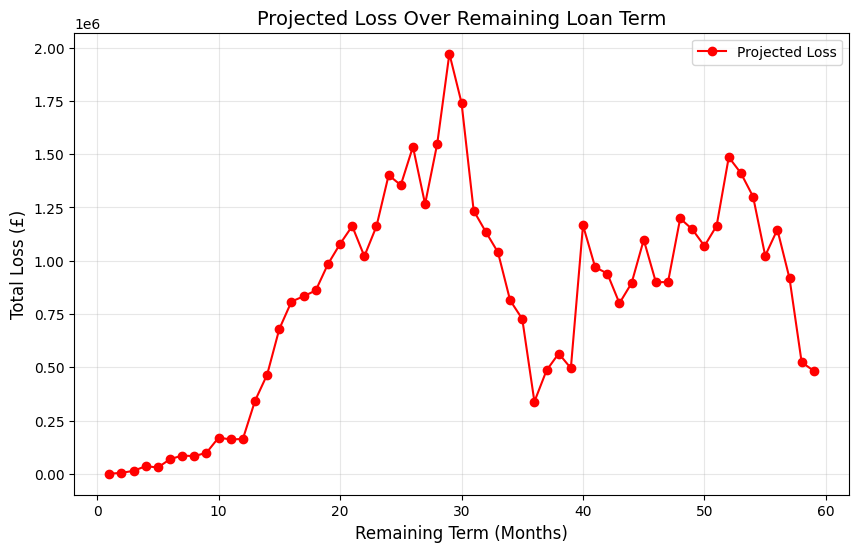

In [29]:
df['months_paid_to_date'] = (df['last_payment_date'] - df['issue_date']).dt.days // 30 # Calculate loan's term paid to date
df['months_left'] = df['term'] - df['months_paid_to_date'] # Calculate remaining term of loan
df = df[df['months_left'] > 0] 

charged_off_loans = df[df['loan_status'] == 'Charged Off'] # Filter loans for Charged Off from transformed dataframe 

aggregated_loss = df[df['loan_status'] == 'Charged Off'].groupby('months_left')['loan_revenue'].sum() # Group charged_off_remaining_months by months_left and sum loan losses

plt.figure(figsize=(10, 6))
plt.plot(aggregated_loss.index, aggregated_loss.values, marker='o', color='red', label='Projected Loss')
plt.title("Projected Loss Over Remaining Loan Term", fontsize=14)
plt.xlabel("Remaining Term (Months)", fontsize=12)
plt.ylabel("Total Loss (£)", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Possible loss:

There are customers who are currently behind with their loan payments. This subset of customers represent a risk to company revenue.

What percentage do users in this bracket currently represent?

Calculate the total amount of customers in this bracket and how much loss the company would incur if their status was changed to Charged Off.

What is the projected loss of these loans if the customer were to finish the full loan term?

If customers that are late on payments converted to Charged Off, what percentage of total expected revenue do these customers and the customers who have already defaulted on their loan represent?

In [30]:
total_loans = len(df)
total_customers = len(df['member_id'].unique()) # Check all loans have unique customer 
print(total_loans)
print(total_customers) 

late_loans = df[df['loan_status'].str.contains("Late")] # Filter loans where loan_status contains string 'Late'
total_customers_late = len(late_loans) # Count of how many loans are late
percentage_late_loans = (total_customers_late / total_loans) * 100 # Calculate percentage of late loans compared to all loans

print(f'Percentage of members behind with their loan payments: {percentage_late_loans:.2f}%')
print(f'Total amount of customers currently behind on their loan payments: {total_customers_late}')

45383
45383
Percentage of members behind with their loan payments: 1.42%
Total amount of customers currently behind on their loan payments: 643


In [31]:
df['loan_left_unpaid'] = df['loan_amount']  - df['total_payment'] # Calculate how much of loan not paid back if changed to Charged Off 
loss_of_late_loans = df.loc[df['loan_status'].str.contains("Late"), 'loan_left_unpaid'].sum() # Sum for all late loans

print(f'Expected loss of loans if customers behind on payments were switched to Charged Off: £{loss_of_late_loans:.2f}')

Expected loss of loans if customers behind on payments were switched to Charged Off: £3272445.40


In [32]:
df['loan_revenue'] = df['total_to_be_paid'] - df['total_payment'] # Calculate loss of revenue from loan 
late_revenue_loss = df.loc[df['loan_status'].str.contains("Late"), 'loan_revenue'].sum() # Sum for all late loans 

print(f'Loss in revenue these loans would have generated if terms had finished: £{late_revenue_loss:.2f}')

Loss in revenue these loans would have generated if terms had finished: £4887522.69


Percentage: 33.03%


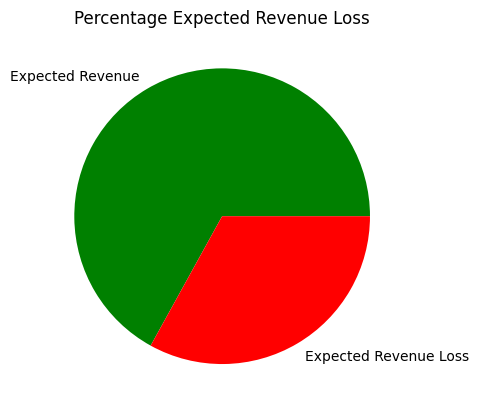

In [33]:
total_expected_revenue = total_to_be_paid - amount_recovered 
total_expected_revenue_loss = charged_off_revenue_loss + late_revenue_loss
percentage_expected_revenue_loss = (total_expected_revenue_loss/total_expected_revenue) * 100 # Calculate percentage of revenue loss for Charged Off and Late loans combined over overall expected revenue

print(f'Percentage: {percentage_expected_revenue_loss:.2f}%')

percentage_expected_revenue = 100 - percentage_expected_revenue_loss
labels = ['Expected Revenue', 'Expected Revenue Loss']
percentages = [percentage_expected_revenue, percentage_expected_revenue_loss]
colors = ['green', 'red']

plt.figure
plt.pie(percentages, labels=labels, colors=colors)
plt.title('Percentage Expected Revenue Loss')
plt.show()


## Indicators of loss:

In this task, you will be analysing the data to visualise the possible indicators that a customer will not be able to pay the loan.

You will want to compare columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

Here are some example columns that might indicate that a user might not pay the loan:
Does the grade of the loan have an effect on customers not paying?
Is the purpose for the loan likely to have an effect?
Does the home_ownership value contribute to the likelihood a customer won't pay?
To help identify which columns will be of interest, first create a subset of these users.

Make the analysis and determine the columns are contributing to loans not being paid off and visualise any interesting indicators.
Compare these indicators between loans already charged off and loans that could change to charged off to check if these same factors apply to loans that have the potential to change to "Charged Off".

In [34]:
charged_off_and_late_df = pd.concat([
        df[df['loan_status'] == 'Charged Off'], 
        df[df['loan_status'].str.contains("Late")]
        ]) # Create subset of customers with Charged Off and Late 

indicators_of_loss = [
    'grade',
    'purpose',
    'home_ownership',
    'employment_length'
    ] # Create list of possible indicators of loss 

for col in indicators_of_loss:
        overall_percentage = (df[col].value_counts() / len(df)) * 100 # Calculate percentage of unique values for indicators of loss columns in main dataframe
        subset_percentage = (charged_off_and_late_df[col].value_counts() / len(charged_off_and_late_df)) * 100 # Calculate percentage of unique values for indicators of loss columns in subset dataframe 

        # Combine into a comparison DataFrame
        comparison_df = pd.DataFrame({
            'Overall (%)': overall_percentage,
            'Charged Off and Late (%)': subset_percentage
        }).fillna(0) # Combine into a comparison DataFrame

        print(f'Comparison for {col}')
        print(comparison_df)

Comparison for grade
       Overall (%)  Charged Off and Late (%)
grade                                       
A        16.466518                  6.999485
B        30.088359                 23.228684
C        25.773968                 26.642649
D        15.435295                 21.684680
E         7.870789                 13.021101
F         3.369103                  6.467662
G         0.995968                  1.955739
Comparison for purpose
                    Overall (%)  Charged Off and Late (%)
purpose                                                  
car                    1.665822                  1.544004
credit_card           21.228213                 16.006176
debt_consolidation    56.433026                 56.733574
educational            0.251195                  0.394579
home_improvement       5.610030                  4.889346
house                  0.636802                  0.686224
major_purchase         2.710266                  2.864985
medical                1.0378

Comparing the combined subset of customers who have stopped paying and are late on payments with customers overall, there seems to be very little difference between the purpose for the loan.

However, there did appear to be a difference for the grade of the loan and home ownership status of the customer. 

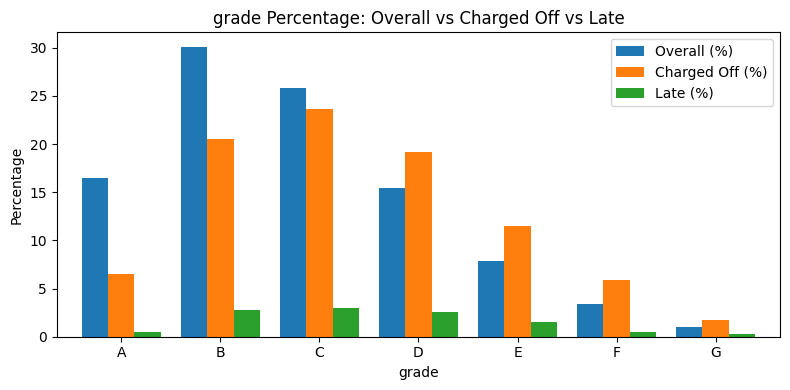

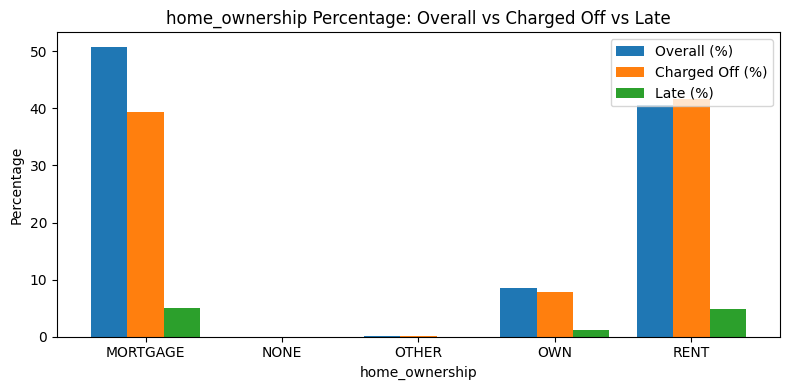

In [36]:
charged_off_df = df[df['loan_status'] == 'Charged Off'] # Create subset for customers who have already stopped payments 
late_df = df[df['loan_status'].str.contains("Late")] # Create subset for customers behind on loan payments 

indicators_of_loss_to_plot = [
    'grade',
    'home_ownership'
    ] # Create list of indicators to visualise

for col in indicators_of_loss_to_plot:
    overall_percentage = (df[col].value_counts() / len(df)) * 100 # Calculate percentage of unique values for selected indicators of loss columns in main dataframe
    charged_off_percentage = (charged_off_df[col].value_counts() / len(charged_off_and_late_df)) * 100 # Calculate percentage of unique values for selected indicators of loss columns in Charged Off dataframe subset
    late_percentage = (late_df[col].value_counts() / len(charged_off_and_late_df)) * 100 # Calculate percentage of unique values for selected indicators of loss columns in Late dataframe subset

    comparison_df = pd.DataFrame({
        'Overall (%)': overall_percentage,
        'Charged Off (%)': charged_off_percentage,
        'Late (%)': late_percentage
    }).fillna(0) # Combine all 3 into a comparison DataFrame

    comparison_df.plot(kind='bar', figsize=(8, 4), width=0.8)
    plt.title(f'{col} Percentage: Overall vs Charged Off vs Late')
    plt.ylabel('Percentage')
    plt.xlabel(f'{col}')
    plt.xticks(rotation=0)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()